Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

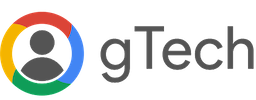

# **gTech Ads Ariel - Dubbing Workflow**

# How to guide



*   You need to have a configured Google Cloud Platform (GCP) project available and API token(s) ready before running, they are all listed on the main GitHub page under the `Requirements` section.
*   You need to run the `Initial setup` section only once.
*   Some cells will require your input and / or action and they are marked in the section header.
*   You will need to run the `Initial setup`, `Dubbing configuration`, `Dubbing configuration - advanced` and `Dubbing` in this notebook to successfully dub your video ad.
*   The cost of running this notebook will only be for the Gemini and Text-To-Speech calls, which will be linked to the provided Google Cloud Platform (GCP) product and optionally to ElevenLabs if you choose so.
*   You are advised to use a GPU kernel when running this notebook to ensure best performance. The dubbing process typically runs less than 1min minute for a 20s video ad. It will run significantly longer if you run it on a CPU or if you run it for the first time, because model files will nee to be downloaded. Switching between CPU and GPU hardware in a Google Colab's is easy.  Simply navigate to either **"Edit > Notebook settings"** or **"Runtime > Change runtime type"** in the menu and choose "GPU" as your Hardware accelerator.
*   For more information, go to the README file fo the Ariel package or post a question [here](https://github.com/google-marketing-solutions/ariel/issues).

# Initial setup
The setup can take around 3-5min.

In [ ]:
%%bash
pip uninstall -y torchvision tf-keras  # Required only in pre-configured Colab environments that might create dependency conflicts
pip install -q gtech-ariel
sudo apt update
sudo apt install -y ffmpeg

# Dubbing configuration
**YOUR INPUT IS REQUIRED HERE**

In [ ]:
# @title  {"vertical-output":true,"display-mode":"form"}
import ast
# @markdown **gcp_project_id** Google Cloud Platform (GCP) project ID for Gemini model access and Google Text-To-Speech API (if this method is picked). You will be prompted to verify yourself in a new window on the first run.
gcp_project_id = "" # @param {type:"string"}
try:
    from google.colab import auth
    auth.authenticate_user(project_id=gcp_project_id)
except ModuleNotFoundError:
    pass

# @markdown **original_language** GCP region to use when making API calls and where a temporary bucket will be created for Gemini to analyze the video / audio ad. The bucket with all its contents will be removed immediately afterwards.
gcp_region = "Iowa - us-central1" # @param ['Santiago - southamerica-west1', 'Iowa - us-central1', 'Oklahoma - us-central2', 'South Carolina - us-east1', 'Northern Virginia - us-east4', 'Columbus - us-east5', 'Unknown - us-east7',  'Dallas - us-south1', 'Oregon - us-west1', 'Los Angeles - us-west2', 'Salt Lake City - us-west3', 'Las Vegas - us-west4', 'Phoenix - us-west8', 'Taiwan - asia-east1', 'Tokyo - asia-northeast1', 'Singapore - asia-southeast1', 'Sydney - australia-southeast1', 'Finland - europe-north1', 'Belgium - europe-west1', 'London - europe-west2', 'Frankfurt - europe-west3', 'Netherlands - europe-west4']
gcp_region = gcp_region.split(" - ")[1]

# @markdown **advertiser_name** The name of the company featured in the ad to improve the speech-to-text accuracy.
advertiser_name = "" # @param {type:"string"}

# @markdown **original_language** The orignal language of the video.
original_language = "English - en-AU" # @param ['Arabic - ar-SA', 'Arabic - ar-EG', 'Bengali - bn-BD', 'Bengali - bn-IN', 'Bulgarian - bg-BG', 'Chinese (Simplified) - zh-CN', 'Chinese (Traditional) - zh-TW', 'Croatian - hr-HR', 'Czech - cs-CZ', 'Danish - da-DK', 'Dutch - nl-NL', 'English - en-US', 'English - en-GB', 'English - en-CA', 'English - en-AU', 'Estonian - et-EE', 'Finnish - fi-FI', 'French - fr-FR', 'French - fr-CA', 'German - de-DE', 'Greek - el-GR', 'Gujarati - gu-IN', 'Hebrew - he-IL', 'Hindi - hi-IN', 'Hungarian - hu-HU', 'Indonesian - id-ID', 'Italian - it-IT', 'Japanese - ja-JP', 'Kannada - kn-IN', 'Korean - ko-KR', 'Latvian - lv-LV', 'Lithuanian - lt-LT', 'Malayalam - ml-IN', 'Marathi - mr-IN', 'Norwegian - nb-NO', 'Norwegian - nn-NO', 'Polish - pl-PL', 'Portuguese - pt-PT', 'Portuguese - pt-BR', 'Romanian - ro-RO', 'Russian - ru-RU', 'Serbian - sr-RS', 'Slovak - sk-SK', 'Slovenian - sl-SI', 'Spanish - es-ES', 'Spanish - es-MX', 'Swahili - sw-KE', 'Swedish - sv-SE', 'Tamil - ta-IN', 'Tamil - ta-LK', 'Telugu - te-IN', 'Thai - th-TH', 'Turkish - tr-TR', 'Ukrainian - uk-UA', 'Vietnamese - vi-VN']
original_language = original_language.split(" - ")[1]

# @markdown **target_language** The target language of the video.
target_language = "Arabic - ar-SA" # @param ['Arabic - ar-SA', 'Arabic - ar-EG', 'Bengali - bn-BD', 'Bengali - bn-IN', 'Bulgarian - bg-BG', 'Chinese (Simplified) - zh-CN', 'Chinese (Traditional) - zh-TW', 'Croatian - hr-HR', 'Czech - cs-CZ', 'Danish - da-DK', 'Dutch - nl-NL', 'English - en-US', 'English - en-GB', 'English - en-CA', 'English - en-AU', 'Estonian - et-EE', 'Finnish - fi-FI', 'French - fr-FR', 'French - fr-CA', 'German - de-DE', 'Greek - el-GR', 'Gujarati - gu-IN', 'Hebrew - he-IL', 'Hindi - hi-IN', 'Hungarian - hu-HU', 'Indonesian - id-ID', 'Italian - it-IT', 'Japanese - ja-JP', 'Kannada - kn-IN', 'Korean - ko-KR', 'Latvian - lv-LV', 'Lithuanian - lt-LT', 'Malayalam - ml-IN', 'Marathi - mr-IN', 'Norwegian - nb-NO', 'Norwegian - nn-NO', 'Polish - pl-PL', 'Portuguese - pt-PT', 'Portuguese - pt-BR', 'Romanian - ro-RO', 'Russian - ru-RU', 'Serbian - sr-RS', 'Slovak - sk-SK', 'Slovenian - sl-SI', 'Spanish - es-ES', 'Spanish - es-MX', 'Swahili - sw-KE', 'Swedish - sv-SE', 'Tamil - ta-IN', 'Tamil - ta-LK', 'Telugu - te-IN', 'Thai - th-TH', 'Turkish - tr-TR', 'Ukrainian - uk-UA', 'Vietnamese - vi-VN']
target_language = target_language.split(" - ")[1]

# @markdown **number_of_speakers** The total number of speakers featured in the add including a lector (if applicable) to improve the unique speaker identification process.
number_of_speakers = "1" # @param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
number_of_speakers = int(number_of_speakers)

# @markdown **hugging_face_token** The token to access the Hugging Face model. You can also pass it via the "HUGGING_FACE_TOKEN" environmental variable. See [here](https://huggingface.co/docs/hub/en/security-tokens) on how to get the token. You will have to accept the HuggingFace conditions to use one of the models, for more details see [here](https://huggingface.co/pyannote/speaker-diarization-3.1).
hugging_face_token = "" # @param {type:"string"}

# Dubbing configuration - advanced
Unfold to get access to the advanced options.

In [ ]:
# @title  {"vertical-output":true,"display-mode":"form"}
import datetime
import os
import re
from ariel.dubbing import get_safety_settings
import tensorflow as tf
# @markdown **output_directory** The full path to the output directory where the dubbed video ad and (optionally) other artifacts will be saved. E.g. in Colab it could look like: "/content/dubbing_output". If empty, you'll be informed anout the output location at the end of the dubbing process.
output_directory = "" # @param {type:"string"}
if not output_directory:
    formatted_advertiser_name = re.sub(r'[^a-zA-Z]', '', advertiser_name).lower()
    now = datetime.datetime.now()
    output_directory = os.path.join("/content", "dubbing_" + formatted_advertiser_name + now.strftime("%Y%m%d%H%M%S%f"))
try:
    tf.io.gfile.makedirs(output_directory)
except Exception:
    output_directory = "dubbing_" + formatted_advertiser_name + now.strftime("%Y%m%d%H%M%S%f")
    tf.io.gfile.makedirs(output_directory)

# @markdown **adjust_speed** Whether to either speed up speech chunks produced by ElevenLabs API or Google's Text-To-Speech when using the "Journey" voice to match the duration of the speech chunks in the source language. It might distort the quality slightly.
adjust_speed = "False" # @param ["True", "False"]
adjust_speed = False if adjust_speed == "False" else True

# @markdown **assigned_voices_override** A mapping between unique speaker IDs and the full name of their assigned voices. E.g. {'speaker_01':'en-US-Casual-K'} or {'speaker_01': 'Charlie'}.
assigned_voices_override = "{}" # @param {type:"string"}
assigned_voices_override = ast.literal_eval(assigned_voices_override)

# @markdown **keep_voice_assignments** Whether the voices assigned on the first run should be used again when utilizing the same class instance. It helps prevents repetitive voice assignment and cloning.
keep_voice_assignments = "True" # @param ["True", "False"]
keep_voice_assignments = False if keep_voice_assignments == "False" else True

# @markdown **preferred_voices** The list of voices from the most to the least preferred, it defaults to the Google Text-To-Speech voices. The names **MUST** include only the base voice name in a list, e.g. ["Journey"] and not ["en-US-Journey-A"]. See [here](https://cloud.google.com/text-to-speech/docs/voices) for the list of all available voices.
# You need to modify this list if you decide to use ElevenLabs API. See the full list of ElevenLabs API voice names (e.g. ['Alice']) [here](https://elevenlabs.io/docs/voices/premade-voices#current-premade-voices)
preferred_voices = '[]' # @param {type:"string"}
preferred_voices = ast.literal_eval(preferred_voices)

# @markdown **no_dubbing_phrases** The list of phrases that should **NOT** be dubbed and left with the orignal voice, e.g. a unique brand slogan.
no_dubbing_phrases = '[]' # @param {type:"string"}
no_dubbing_phrases = ast.literal_eval(no_dubbing_phrases)

# @markdown **merge_speech_chunks** The indicator whether to merge detected speech chunks where the break between them is less than "minimum_merge_threshold".
merge_speech_chunks = "True" # @param ["True", "False"]
merge_speech_chunks = False if merge_speech_chunks == "False" else True

# @markdown **minimum_merge_threshold** The minimum threshold (expressed in seconds) to keep the two speech chunks as spearate, any speech chunks with the time difference lower than that will be merged if "merge_speech_chunks" is True.
minimum_merge_threshold = "0.001" # @param {type:"string"}
minimum_merge_threshold = float(minimum_merge_threshold)

# @markdown **vocals_volume_adjustment** By how much the vocals audio volume should be adjusted.
vocals_volume_adjustment = "5.0" # @param {type:"string"}
vocals_volume_adjustment = float(vocals_volume_adjustment)

# @markdown **background_volume_adjustment** By how much the background audio volume should be adjusted.
background_volume_adjustment = "0.0" # @param {type:"string"}
background_volume_adjustment = float(background_volume_adjustment)

# @markdown **elevenlabs_token** It is only required if you decide to use ElevenLabs API for the highest quality voiceover. The token to access the ElevenLabs API. You can also pass it via the "ELEVENLABS_TOKEN" environmental variable. See [here](https://help.elevenlabs.io/hc/en-us/articles/14599447207697-How-to-authorize-yourself-using-your-xi-api-key) how to get the token.
elevenlabs_token = "" # @param {type:"string"}
if original_language == "he-IL" or target_language == "he-IL" or (not elevenlabs_token and not os.getenv("ELEVENLABS_TOKEN")):
    use_elevenlabs = False
else:
    use_elevenlabs = True

# @markdown **elevenlabs_clone_voices** Whether to to use ElevenLabs API to clone source voices. **WARNING:** This ElevenLabs API functionality might require higher tier pricing. See the pricing [here](https://elevenlabs.io/pricing).
elevenlabs_clone_voices = "False" # @param ["True", "False"]
elevenlabs_clone_voices = False if elevenlabs_clone_voices == "False" else True

# @markdown **elevenlabs_remove_cloned_voices** The indicator whether a user wishes to remove cloned voices after the process finishes.
elevenlabs_remove_cloned_voices = "False" # @param ["True", "False"]
elevenlabs_remove_cloned_voices = False if elevenlabs_remove_cloned_voices == "False" else True

# @markdown **elevenlabs_model** The ElevenLabs model to use during the dubbing process. `eleven_multilingual_v2` will generate better results.
elevenlabs_model = "eleven_multilingual_v2" # @param ["eleven_multilingual_v2", "eleven_turbo_v2_5"]

# @markdown **gemini_model_name** The Gemini model to use. See [here](https://ai.google.dev/gemini-api/docs/models/gemini) to see all available models.
gemini_model_name = "gemini-1.5-flash" # @param {type:"string"}

# @markdown **gemini_safety_settings** The indicator of what kind of Gemini safety settings should be used in the dubbing process.
gemini_safety_settings = "Medium" # @param ["Low", "Medium", "High", "None"]
gemini_safety_settings = get_safety_settings(gemini_safety_settings)

# @markdown **gemini_speaker_identification_instructions** The prompt you can pass to Gemini to help it with the unique speaker identification process. E.g. "There is a female speaker at the 10.00s of the video.". You don't have to input anything if you don't have any specific instructions.
gemini_speaker_identification_instructions = "" # @param {type:"string"}

# @markdown **gemini_translation_instructions** The prompt you can pass to Gemini to help it with the translation process. E.g. "Translate "2.5 million" to "two and a half million" and don't translate "What else?" phrase.". You don't have to input anything if you don't have any specific instructions.
gemini_translation_instructions = "" # @param {type:"string"}

# @markdown **gemini_temperature** Controls the randomness of the Gemini model's output. Higher values (e.g., 1.0) make output more creative and diverse, while lower values (e.g., 0.2) make it more focused and deterministic.
gemini_temperature = "1.0" # @param {type:"string"}
gemini_temperature = float(gemini_temperature)

# @markdown **gemini_top_p** Controls the cumulative probability threshold for sampling the next token. For example, a value of 0.9 means that only tokens with a cumulative probability of 90% or higher will be considered.
gemini_top_p = "0.95" # @param {type:"string"}
gemini_top_p = float(gemini_top_p)

# @markdown **gemini_top_k** Limits the model to considering the top k most likely tokens at each step. A higher value increases diversity but may introduce less likely words.
gemini_top_k = "40" # @param {type:"string"}
gemini_top_k = int(gemini_top_k)

# @markdown **gemini_maximum_output_tokens** The maximum number of tokens the model is allowed to generate in its response. Prevents excessively long outputs.
gemini_maximum_output_tokens = "8192" # @param {type:"string"}
gemini_maximum_output_tokens = int(gemini_maximum_output_tokens)

# @markdown **clean_up** The indicator if to remove all artifacts in the output directory except the dubbed video / audio file and the speech chunks (utterance) metadata.
clean_up = "False" # @param ["True", "False"]
clean_up = False if clean_up == "False" else True

# @markdown **with_verification** The indicator whether a user wishes to verify, and optionally edit, the speech chunks (utterance) metadata in the dubbing process.
with_verification = "True" # @param ["True", "False"]
with_verification = False if with_verification == "False" else True


# Dubbing
Make sure the "Dubbing" section is unfolded, so you can see all the progress and user prompts.

In [ ]:
# @title  {"vertical-output":true,"display-mode":"form"}
# @markdown
from ariel.dubbing import Dubber

# @markdown **input_filepath** The full path to the video or audio file you want to dub in a foreign language. You don't need to provide it if you run Ariel in Colab, you will be prompted to upload the file directly.
input_filepath = "" # @param {type:"string"}

# @markdown **automatic_download** The indicator if to download the dubbed outputs (1. dubbed video, 2. dubbed audio, 3. metadata, 4. dubbed subtitles) as soon as the process finishes. It works only if you run in Colab. Else, you'll need to download the outputs with the provided paths.
automatic_download = "True" # @param ["True", "False"]
automatic_download = False if automatic_download == "False" else True

if not input_filepath or not tf.io.gfile.exists(input_filepath):
    try:
        from google.colab import files
        uploaded_file = files.upload()
        input_filepath = os.path.join("/content", list(uploaded_file.keys())[0])
    except ModuleNotFoundError:
        pass

dubber = Dubber(
      input_file=input_filepath,
      output_directory=output_directory,
      advertiser_name=advertiser_name,
      original_language=original_language,
      target_language=target_language,
      gcp_project_id=gcp_project_id,
      gcp_region=gcp_region,
      number_of_speakers=number_of_speakers,
      hugging_face_token=hugging_face_token,
      no_dubbing_phrases=no_dubbing_phrases,
      diarization_instructions=gemini_speaker_identification_instructions,
      translation_instructions=gemini_translation_instructions,
      merge_utterances=merge_speech_chunks,
      minimum_merge_threshold=minimum_merge_threshold,
      preferred_voices=preferred_voices,
      assigned_voices_override=assigned_voices_override,
      keep_voice_assignments=keep_voice_assignments,
      adjust_speed=adjust_speed,
      vocals_volume_adjustment=vocals_volume_adjustment,
      background_volume_adjustment=background_volume_adjustment,
      clean_up=clean_up,
      gemini_model_name=gemini_model_name,
      temperature=gemini_temperature,
      top_p=gemini_top_p,
      top_k=gemini_top_k,
      max_output_tokens=gemini_maximum_output_tokens,
      safety_settings=gemini_safety_settings,
      use_elevenlabs=use_elevenlabs,
      elevenlabs_token=elevenlabs_token,
      elevenlabs_clone_voices=elevenlabs_clone_voices,
      elevenlabs_model=elevenlabs_model,
      elevenlabs_remove_cloned_voices=elevenlabs_remove_cloned_voices,
      with_verification=with_verification,
  )
dubbed_output = dubber.dub_ad()
if automatic_download:
    try:
        files.download(dubbed_output.audio_file)
        if dubbed_output.video_file:
            files.download(dubbed_output.video_file)
        files.download(dubbed_output.utterance_metadata)
        files.download(dubbed_output.subtitles)
    except NameError:
        print(f"All the file are available for download under: {output_directory}")
        pass

# Dubbing into more langauges
Go through this section if you wish to dub your ad into another language during the same session.

In [ ]:
# @title  {"vertical-output":true,"display-mode":"form"}
# @markdown **new_target_language** The new target language of the video ad.
new_target_language = "Arabic - ar-SA" # @param ['Arabic - ar-SA', 'Arabic - ar-EG', 'Bengali - bn-BD', 'Bengali - bn-IN', 'Bulgarian - bg-BG', 'Chinese (Simplified) - zh-CN', 'Chinese (Traditional) - zh-TW', 'Croatian - hr-HR', 'Czech - cs-CZ', 'Danish - da-DK', 'Dutch - nl-NL', 'English - en-US', 'English - en-GB', 'English - en-CA', 'English - en-AU', 'Estonian - et-EE', 'Finnish - fi-FI', 'French - fr-FR', 'French - fr-CA', 'German - de-DE', 'Greek - el-GR', 'Gujarati - gu-IN', 'Hebrew - he-IL', 'Hindi - hi-IN', 'Hungarian - hu-HU', 'Indonesian - id-ID', 'Italian - it-IT', 'Japanese - ja-JP', 'Kannada - kn-IN', 'Korean - ko-KR', 'Latvian - lv-LV', 'Lithuanian - lt-LT', 'Malayalam - ml-IN', 'Marathi - mr-IN', 'Norwegian - nb-NO', 'Norwegian - nn-NO', 'Polish - pl-PL', 'Portuguese - pt-PT', 'Portuguese - pt-BR', 'Romanian - ro-RO', 'Russian - ru-RU', 'Serbian - sr-RS', 'Slovak - sk-SK', 'Slovenian - sl-SI', 'Spanish - es-ES', 'Spanish - es-MX', 'Swahili - sw-KE', 'Swedish - sv-SE', 'Tamil - ta-IN', 'Tamil - ta-LK', 'Telugu - te-IN', 'Thai - th-TH', 'Turkish - tr-TR', 'Ukrainian - uk-UA', 'Vietnamese - vi-VN']
new_target_language = new_target_language.split(" - ")[1]

# @markdown **overwrite_metadata** Whether the JSON file with speech chunk metadata from the previous output should be overwritten.
overwrite_metadata = "False" # @param ["True", "False"]
overwrite_metadata = False if overwrite_metadata == "False" else True

dubber.dub_ad_with_different_language(target_language=new_target_language, overwrite_utterance_metadata=overwrite_metadata)

if automatic_download:
    try:
        from google.colab import files
        files.download(dubbed_output.audio_file)
        if dubbed_output.video_file:
            files.download(dubbed_output.video_file)
        files.download(dubbed_output.utterance_metadata)
        files.download(dubbed_output.subtitles)
    except ModuleNotFoundError:
        print(f"All the file are available for download under: {output_directory}")
        pass

# Advanced methods
Explore alternative Ariel methods to augment your workflow.

*   To speed up the dubbing process Ariel can dub directly form the JSON file with speech chunk metadata.
    * You need to use `dubber.dub_ad_with_utterance_metadata()` method. For more go [here](https://github.com/google-marketing-solutions/ariel/blob/main/ariel/dubbing.py#L1809).

*   Ariel can also dub videos from a text script.
    * You need to use `dubber.dub_ad_from_script()` method. For more go [here](https://github.com/google-marketing-solutions/ariel/blob/main/ariel/dubbing.py#L1947).